In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/archive.zip"

Archive:  /content/drive/MyDrive/archive.zip
  inflating: physiobank_database_sleep-edfx_sleep-cassette/SC4001E0-PSG.edf  
  inflating: physiobank_database_sleep-edfx_sleep-cassette/SC4001EC-Hypnogram.edf  
  inflating: physiobank_database_sleep-edfx_sleep-cassette/SC4002E0-PSG.edf  
  inflating: physiobank_database_sleep-edfx_sleep-cassette/SC4002EC-Hypnogram.edf  
  inflating: physiobank_database_sleep-edfx_sleep-cassette/SC4011E0-PSG.edf  
  inflating: physiobank_database_sleep-edfx_sleep-cassette/SC4011EH-Hypnogram.edf  
  inflating: physiobank_database_sleep-edfx_sleep-cassette/SC4012E0-PSG.edf  
  inflating: physiobank_database_sleep-edfx_sleep-cassette/SC4012EC-Hypnogram.edf  
  inflating: physiobank_database_sleep-edfx_sleep-cassette/SC4021E0-PSG.edf  
  inflating: physiobank_database_sleep-edfx_sleep-cassette/SC4021EH-Hypnogram.edf  
  inflating: physiobank_database_sleep-edfx_sleep-cassette/SC4022E0-PSG.edf  
  inflating: physiobank_database_sleep-edfx_sleep-cassette/SC4022EJ

In [ ]:
!mv "/content/physiobank_database_sleep-edfx_sleep-cassette" "/content/drive/MyDrive/CapstoneDataset"

mv: inter-device move failed: '/content/physiobank_database_sleep-edfx_sleep-cassette' to '/content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette'; unable to remove target: Directory not empty


In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 82.2 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import mne
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import os
import numpy as np
import mne
from difflib import get_close_matches

def find_closest_hypnogram(psg_filename, hypnogram_files):
    """Finds the closest matching hypnogram file for a given PSG file."""
    base_name = psg_filename.replace('-PSG.edf', '')
    matches = get_close_matches(base_name, hypnogram_files, n=1, cutoff=0.4)

    if matches:
        return matches[0]
    return None

def load_data(data_path):
    psg_files = sorted([f for f in os.listdir(data_path) if '-PSG.edf' in f])
    hypnogram_files = sorted([f for f in os.listdir(data_path) if '-Hypnogram.edf' in f])

    X, y = [], []

    for psg_file in psg_files:
        edf_path = os.path.join(data_path, psg_file)
        hypnogram_file = find_closest_hypnogram(psg_file, hypnogram_files)

        if not hypnogram_file:
            print(f"No hypnogram found for {psg_file}. Skipping...")
            continue

        hypnogram_path = os.path.join(data_path, hypnogram_file)
        print(f"Matching {psg_file} with {hypnogram_file}")

        raw = mne.io.read_raw_edf(edf_path, preload=True)
        raw.pick_channels(['EEG Fpz-Cz'])
        raw.resample(100)
        eeg_data = raw.get_data()[0]

        annotations = mne.read_annotations(hypnogram_path)
        if len(annotations) == 0:
            print(f"No annotations found in {hypnogram_file}. Skipping...")
            continue

        sleep_stages = []
        for desc, onset, duration in zip(annotations.description, annotations.onset, annotations.duration):
            if 'Sleep stage' in desc:
                try:
                    stage = int(desc.replace('Sleep stage ', ''))
                    num_epochs = int(duration / 30)
                    sleep_stages.extend([stage] * num_epochs)
                except ValueError:
                    continue

        if len(sleep_stages) == 0:
            print(f"No valid sleep stages extracted from {hypnogram_file}. Skipping...")
            continue

        epoch_length = 30 * 100
        num_epochs = min(len(eeg_data) // epoch_length, len(sleep_stages))

        for i in range(num_epochs):
            X.append(eeg_data[i * epoch_length:(i + 1) * epoch_length])
            y.append(sleep_stages[i])

    return np.array(X), np.array(y)

data_path = "/content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette"
X, y = load_data(data_path)

print(f"\nFinal dataset shape: X={X.shape}, y={y.shape}")


Matching SC4001E0-PSG.edf with SC4001EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4002E0-PSG.edf with SC4002EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4011E0-PSG.edf with SC4011EH-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4012E0-PSG.edf with SC4012EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8549999  =      0.000 ... 85499.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4541F0-PSG.edf with SC4541FA-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4541F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8219999  =      0.000 ... 82199.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4542F0-PSG.edf with SC4542FW-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4542F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8039999  =      0.000 ... 80399.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4551F0-PSG.edf with SC4551FC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4551F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8315999  =      0.000 ... 83159.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4552F0-PSG.edf with SC4552FW-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4552F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4561F0-PSG.edf with SC4571FV-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4561F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8111999  =      0.000 ... 81119.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4562F0-PSG.edf with SC4562FJ-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4562F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8399999  =      0.000 ... 83999.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4571F0-PSG.edf with SC4571FV-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4571F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8549999  =      0.000 ... 85499.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4572F0-PSG.edf with SC4572FC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4572F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8639999  =      0.000 ... 86399.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4581G0-PSG.edf with SC4581GM-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4581G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8213999  =      0.000 ... 82139.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4582G0-PSG.edf with SC4582GP-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4582G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7901999  =      0.000 ... 79019.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4591G0-PSG.edf with SC4591GY-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4591G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8459999  =      0.000 ... 84599.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4592G0-PSG.edf with SC4592GY-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4592G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6119999  =      0.000 ... 61199.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4601E0-PSG.edf with SC4601EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4601E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8189999  =      0.000 ... 81899.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4602E0-PSG.edf with SC4602EJ-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4602E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8399999  =      0.000 ... 83999.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4611E0-PSG.edf with SC4611EG-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4611E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4612E0-PSG.edf with SC4612EA-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4612E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8189999  =      0.000 ... 81899.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4621E0-PSG.edf with SC4621EV-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4621E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7835999  =      0.000 ... 78359.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4622E0-PSG.edf with SC4622EJ-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4622E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8567999  =      0.000 ... 85679.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4631E0-PSG.edf with SC4631EM-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4631E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8273999  =      0.000 ... 82739.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4632E0-PSG.edf with SC4632EA-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4632E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8543999  =      0.000 ... 85439.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4641E0-PSG.edf with SC4641EP-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4641E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8039999  =      0.000 ... 80399.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4642E0-PSG.edf with SC4642EP-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4642E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8369999  =      0.000 ... 83699.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4651E0-PSG.edf with SC4651EP-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4651E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8579999  =      0.000 ... 85799.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4652E0-PSG.edf with SC4652EG-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4652E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8519999  =      0.000 ... 85199.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4661E0-PSG.edf with SC4661EJ-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4661E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8219999  =      0.000 ... 82199.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4662E0-PSG.edf with SC4662EJ-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4662E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8459999  =      0.000 ... 84599.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4671G0-PSG.edf with SC4671GJ-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4671G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8339999  =      0.000 ... 83399.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4672G0-PSG.edf with SC4672GV-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4672G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7739999  =      0.000 ... 77399.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4701E0-PSG.edf with SC4701EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4701E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8039999  =      0.000 ... 80399.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4702E0-PSG.edf with SC4702EA-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4702E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7871999  =      0.000 ... 78719.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4711E0-PSG.edf with SC4711EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4711E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8189999  =      0.000 ... 81899.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4712E0-PSG.edf with SC4712EA-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4712E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8459999  =      0.000 ... 84599.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4721E0-PSG.edf with SC4721EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4721E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7025999  =      0.000 ... 70259.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4722E0-PSG.edf with SC4722EM-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4722E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8237999  =      0.000 ... 82379.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4731E0-PSG.edf with SC4731EM-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4731E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8339999  =      0.000 ... 83399.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4732E0-PSG.edf with SC4732EJ-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4732E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7559999  =      0.000 ... 75599.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4741E0-PSG.edf with SC4741EA-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4741E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8069999  =      0.000 ... 80699.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4742E0-PSG.edf with SC4742EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4742E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4751E0-PSG.edf with SC4751EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4751E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8039999  =      0.000 ... 80399.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4752E0-PSG.edf with SC4752EM-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4752E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7409999  =      0.000 ... 74099.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4761E0-PSG.edf with SC4761EP-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4761E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7889999  =      0.000 ... 78899.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4762E0-PSG.edf with SC4762EG-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4762E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4771G0-PSG.edf with SC4771GC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4771G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8267999  =      0.000 ... 82679.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4772G0-PSG.edf with SC4772GC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4772G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6725999  =      0.000 ... 67259.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4801G0-PSG.edf with SC4801GC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4801G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8321999  =      0.000 ... 83219.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4802G0-PSG.edf with SC4802GV-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4802G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4811G0-PSG.edf with SC4811GG-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4811G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7205999  =      0.000 ... 72059.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4812G0-PSG.edf with SC4812GV-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4812G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7247999  =      0.000 ... 72479.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4821G0-PSG.edf with SC4821GC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4821G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8165999  =      0.000 ... 81659.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
Matching SC4822G0-PSG.edf with SC4822GC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/CapstoneDataset/physiobank_database_sleep-edfx_sleep-cassette/SC4822G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 secs...


<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
<ipython-input-4-b24427b2692f>:34: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.

Final dataset shape: X=(37895, 3000), y=(37895,)


### DNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_val = scaler.transform(X_val.reshape(X_val.shape[0], -1))
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1))

input_shape = (X_train.shape[1],)

print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_val:", np.unique(y_val))
print("Unique labels in y_test:", np.unique(y_test))

num_classes = len(np.unique(y))
print(f"Detected {num_classes} classes")

y_train -= np.min(y_train)
y_val -= np.min(y_val)
y_test -= np.min(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = Sequential([
    Dense(128, activation='relu', input_shape=input_shape),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    verbose=1)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")


Unique labels in y_train: [1 2 3 4]
Unique labels in y_val: [1 2 3 4]
Unique labels in y_test: [1 2 3 4]
Detected 4 classes


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6180 - loss: 1.0684 - val_accuracy: 0.6546 - val_loss: 0.9055
Epoch 2/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.6552 - loss: 0.9121 - val_accuracy: 0.6546 - val_loss: 0.8850
Epoch 3/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6536 - loss: 0.8938 - val_accuracy: 0.6546 - val_loss: 0.8791
Epoch 4/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6575 - loss: 0.8788 - val_accuracy: 0.6546 - val_loss: 0.8776
Epoch 5/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6490 - loss: 0.8886 - val_accuracy: 0.6546 - val_loss: 0.8788
Epoch 6/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6483 - loss: 0.8815 - val_accuracy: 0.6546 - val_loss: 0.8765
Epoch 7/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6565 - loss: 0.8711 - val_accuracy: 0.6546 - val_loss: 0.8765
Epoch 8/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6574 - loss: 0.8665 - val_accu

178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.00      0.01      1552
           1       0.64      0.99      0.78      3655
           2       0.07      0.01      0.02       376
           3       0.00      0.00      0.00       102

    accuracy                           0.64      5685
   macro avg       0.23      0.25      0.20      5685
weighted avg       0.47      0.64      0.50      5685

Confusion Matrix:
[[   6 1525   21    0]
 [  21 3601   33    0]
 [   3  369    4    0]
 [   1  100    1    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


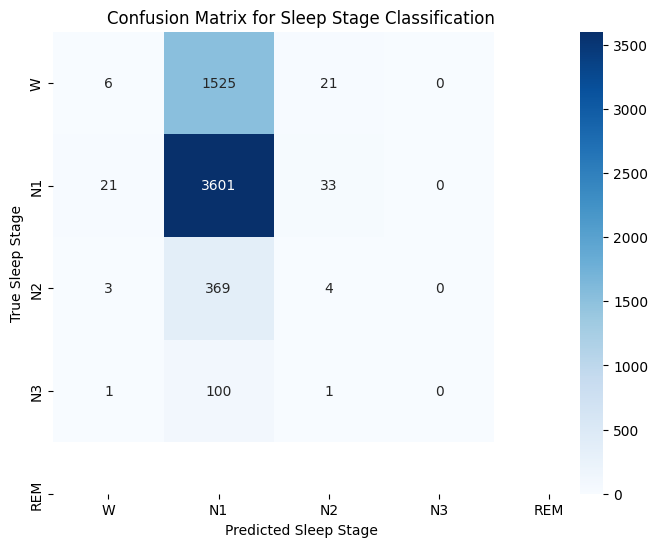


Predicted Sleep Stages (first 10):
Predicted: N1, True: N1
Predicted: N1, True: N1
Predicted: N1, True: N3
Predicted: N1, True: N1
Predicted: N1, True: N1
Predicted: N1, True: N1
Predicted: N1, True: N3
Predicted: N1, True: N1
Predicted: N1, True: N1
Predicted: N1, True: W


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['W', 'N1', 'N2', 'N3', 'REM'], yticklabels=['W', 'N1', 'N2', 'N3', 'REM'])
plt.ylabel('True Sleep Stage')
plt.xlabel('Predicted Sleep Stage')
plt.title('Confusion Matrix for Sleep Stage Classification')
plt.show()

stage_mapping = {
    0: 'W',
    1: 'N1',
    2: 'N2',
    3: 'N3',
    4: 'REM'
}

predicted_stages = [stage_mapping[label] for label in y_pred_classes[:10]]
true_stages = [stage_mapping[label] for label in y_true_classes[:10]]

print("\nPredicted Sleep Stages (first 10):")
for pred, true in zip(predicted_stages, true_stages):
    print(f"Predicted: {pred}, True: {true}")

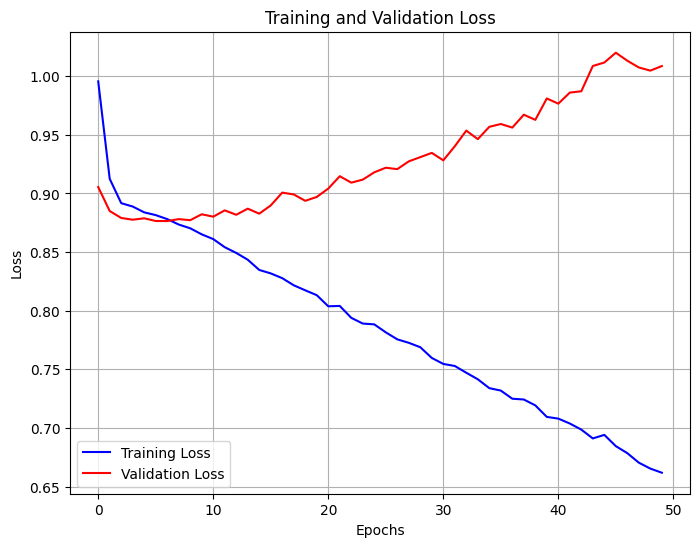

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Split dataset into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_val = scaler.transform(X_val.reshape(X_val.shape[0], -1))
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1))

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train -= y_train.min()
y_val -= y_val.min()
y_test -= y_test.min()

num_classes = len(np.unique(y_train))
print(f"Detected {num_classes} classes: {np.unique(y_train)}")

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = Sequential([
    Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    verbose=1)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

Detected 4 classes: [0 1 2 3]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.6312 - loss: 0.9773 - val_accuracy: 0.6546 - val_loss: 0.8708
Epoch 2/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.6522 - loss: 0.8798 - val_accuracy: 0.6546 - val_loss: 0.8664
Epoch 3/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.6514 - loss: 0.8563 - val_accuracy: 0.6550 - val_loss: 0.8695
Epoch 4/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.6593 - loss: 0.7995 - val_accuracy: 0.6500 - val_loss: 0.9060
Epoch 5/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7130 - loss: 0.6612 - val_accuracy: 0.5855 - val_loss: 1.0867
Epoch 6/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.7957 - loss: 0.4945 - val_accuracy: 0.5611 - val_loss: 1.2245
Epoch 7/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.8612 - loss: 0.3467 - val_accuracy: 0.5902 - val_loss: 1.6032
Epoch 8/50
856/856 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9020 - loss: 0.2637 - 

178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.21      0.24      1552
           1       0.64      0.75      0.69      3655
           2       0.11      0.06      0.08       376
           3       0.09      0.01      0.02       102

    accuracy                           0.54      5685
   macro avg       0.28      0.26      0.26      5685
weighted avg       0.50      0.54      0.51      5685



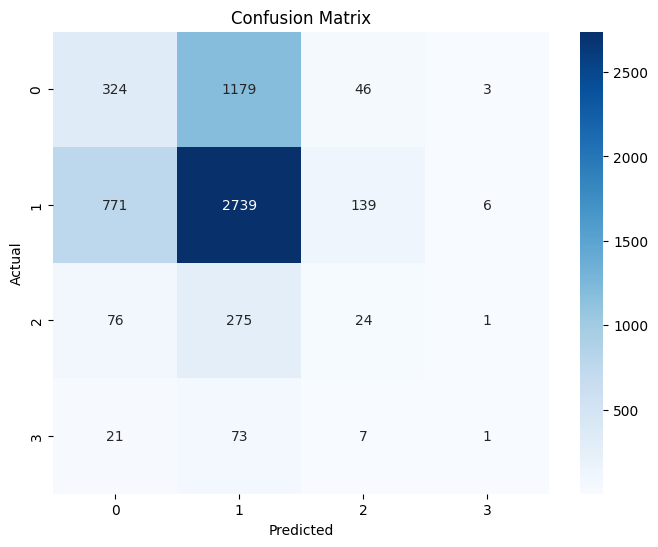

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

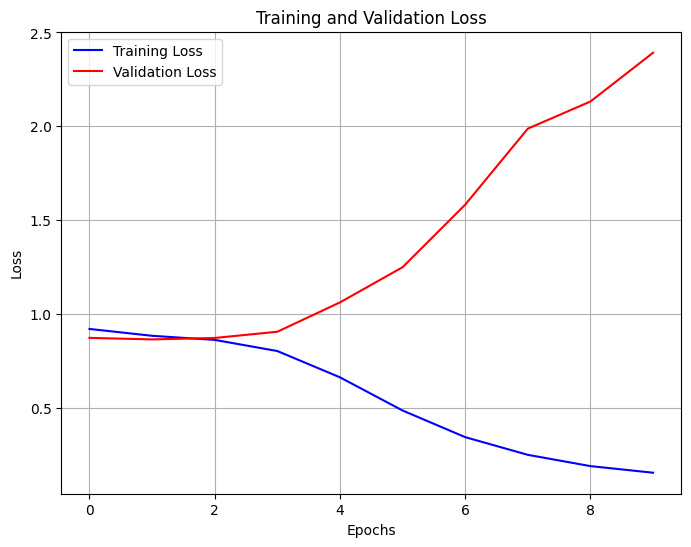

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()